In [1]:
import os
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pathlib import Path
from shutil import copyfile
import tensorflow as tf
# import torch
import torch
import torch.nn as nn
import torch.optim as Adam
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip "/content/drive/MyDrive/BRAIT/dataset-BRAIT.zip"

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: dataset/train/s/P_20180609_101929_6_2_1.jpg  
  inflating: dataset/train/s/P_20180609_101929_6_2_1_1.jpg  
  inflating: dataset/train/s/P_20180609_101929_6_2_1_2.jpg  
  inflating: dataset/train/s/P_20180609_165647_2.jpg  
  inflating: dataset/train/s/S(w1).jpg  
  inflating: dataset/train/s/S(w2).jpg  
  inflating: dataset/train/s/s_1.jpg  
  inflating: dataset/train/s/s_1_result.jpg  
  inflating: dataset/train/s/s_1_result_result.jpg  
  inflating: dataset/train/s/s_10.jpg  
  inflating: dataset/train/s/s_10_result.jpg  
  inflating: dataset/train/s/s_10_result_result.jpg  
  inflating: dataset/train/s/s_100.jpg  
  inflating: dataset/train/s/s_100_1.jpg  
  inflating: dataset/train/s/s_100_1_result.jpg  
  inflating: dataset/train/s/s_100_1_result_result.jpg  
  inflating: dataset/train/s/s_100_result.jpg  
  inflating: dataset/train/s/s_100_result_result.jpg  
  inflating: dataset/train/s/s_101.jpg  
  inflati

In [4]:
torch.cuda.is_available()

True

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [6]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((28, 28))
        ]),
    'validation': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((28, 28))
        ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((28, 28))
        ]),
}

In [7]:
# Define the data directory
data_dir = '/content/dataset'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

In [8]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20, shuffle=True) for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 12805, 'validation': 1602}


['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [9]:
print(f'Number of batches in the training set: {int(13171 / 20)}')
print(f'Number of batches in the training set: {int(1648 / 20)}')

Number of batches in the training set: 658
Number of batches in the training set: 82


In [10]:
trainloader = torch.utils.data.DataLoader(image_datasets, batch_size=20,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(image_datasets, batch_size=5,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(image_datasets, batch_size=5,
                                         shuffle=False)

In [11]:
import torch.nn.functional as F

class BRAIT_CNN(nn.Module):
  def __init__(self):
    super(BRAIT_CNN, self).__init__()
    self.brait1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(p=0.01))
    self.brait2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(p=0.01))
    self.brait3 = nn.Sequential(
        nn.Linear(32*7*7, 100),
        nn.Linear(100, 26))

  def forward(self, x):
    y = F.relu(self.brait1(x))
    y = F.relu(self.brait2(y))

    #flatten
    y = y.view(-1, 32*7*7)
    y = F.relu(self.brait3(y))

    return y

In [12]:
model = BRAIT_CNN()

In [13]:
# print summary of the neural network model to check if everything is fine.
print(model)
print("# parameter: ", sum([param.nelement() for param in model.parameters()]))

BRAIT_CNN(
  (brait1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.01, inplace=False)
  )
  (brait2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.01, inplace=False)
  )
  (brait3): Sequential(
    (0): Linear(in_features=1568, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=26, bias=True)
  )
)
# parameter:  173574


In [14]:
model.to(device)

BRAIT_CNN(
  (brait1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.01, inplace=False)
  )
  (brait2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.01, inplace=False)
  )
  (brait3): Sequential(
    (0): Linear(in_features=1568, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=26, bias=True)
  )
)

In [15]:
# Define the learning rate, loss function, and optimizer
from torch import optim
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
# Training loop
num_epochs = 15

# Initialize empty lists to store training loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        # Save the loss and accuracy values
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print()

print("Training complete!")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


train Loss: 3.2469 Acc: 0.0534

validation Loss: 3.2402 Acc: 0.0574

train Loss: 1.7801 Acc: 0.5435

validation Loss: 0.9925 Acc: 0.7978

train Loss: 0.6200 Acc: 0.8647

validation Loss: 0.8206 Acc: 0.8277

train Loss: 0.4509 Acc: 0.8927

validation Loss: 0.6428 Acc: 0.8895

train Loss: 0.3272 Acc: 0.9245

validation Loss: 0.7881 Acc: 0.8377

train Loss: 0.3153 Acc: 0.9197

validation Loss: 0.6507 Acc: 0.8789

train Loss: 0.3000 Acc: 0.9275

validation Loss: 0.4762 Acc: 0.8983

train Loss: 0.2795 Acc: 0.9301

validation Loss: 0.5011 Acc: 0.8933

train Loss: 0.2627 Acc: 0.9302

validation Loss: 0.5441 Acc: 0.9039

train Loss: 0.2652 Acc: 0.9310

validation Loss: 0.5975 Acc: 0.8970

train Loss: 0.2613 Acc: 0.9314

validation Loss: 0.5612 Acc: 0.9051

train Loss: 0.2457 Acc: 0.9335

validation Loss: 0.6455 Acc: 0.8958

train Loss: 0.2416 Acc: 0.9342

validation Loss: 0.5677 Acc: 0.8901

train Loss: 0.2396 Acc: 0.9345

validation Loss: 0.6455 Acc: 0.9051

train Loss: 0.2226 Acc: 0.9389

va

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

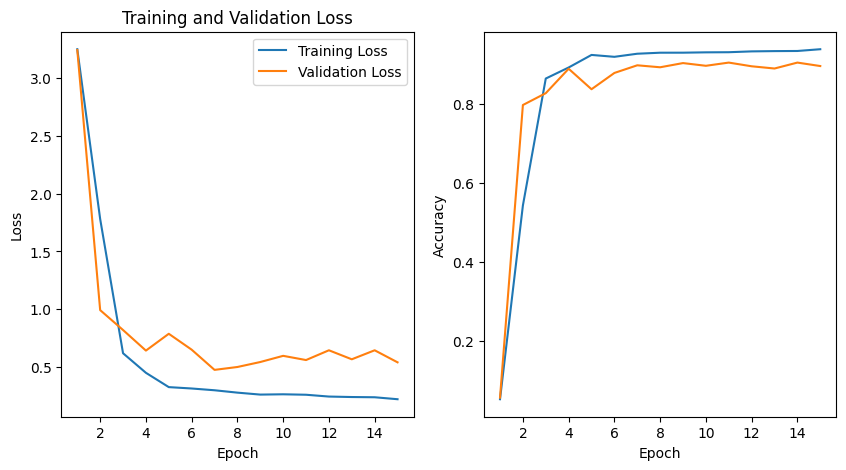

In [17]:
# Plotting
plt.figure(figsize=(10, 5))

# Plotting training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt

In [18]:
# Save the model
torch.save(model.state_dict(), 'BRAIT_PYTORCH.pth')